In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from time import time
import torch
from TextEnrichers import get_enricher, TextEnricher
from database.database import Database
from Embedders import Embedder, get_embedder
from tqdm import tqdm
from pprint import pprint
import numpy as np

load_dotenv(".env", override=True)

db = Database()
db.test_connection()

=================================CONFIG=================================
Database         User             Host                             Port            
citeline_db      bbasseri         localhost                        5432            
Database version: ('PostgreSQL 17.3 (Homebrew) on x86_64-apple-darwin23.6.0, compiled by Apple clang version 16.0.0 (clang-1600.0.26.6), 64-bit',)


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu'
print(f"Using device: {device}")
examples = pd.read_json('data/dataset/100/nontrivial.jsonl', lines=True)
print(f"Loaded {len(examples)} examples")

Using device: mps
Loaded 100 examples


In [3]:
def get_index_of_target(query_results, target_doi: str) -> int:
    """
    Get the index of the target DOI in the query results.
    :param query_results: The query results from the database.
    :param target_doi: The DOI of the target paper.
    :return: The index of the target DOI in the query results.
    """
    for i, result in enumerate(query_results):
        if result.doi == target_doi:
            return i
    return -1

def get_query_results_and_ranks(examples, embedder, enricher, target_column) -> list[int]:
    all_query_results = []
    target_ranks = []
    # Enrich and embed the sentences
    enriched_sentences = enricher(examples)
    embeddings = embedder(enriched_sentences)

    for i, embedding in tqdm(enumerate(embeddings)):
        pubdate = examples.iloc[i]['pubdate']
        target_doi = examples.iloc[i]['citation_dois'][0]

        query_results = db.query_vector_column(
            query_vector=embedding,
            table_name="lib",
            target_column=target_column,
            pubdate=pubdate,
            top_k=10_000,
            probes=40,
            explain=False,
        )
        all_query_results.append(query_results)

        # Get the rank of the target DOI in the query results
        target_rank = get_index_of_target(query_results, target_doi)
        target_ranks.append(target_rank)
    return all_query_results, target_ranks

In [4]:
# BGE with identity experiment
bge_embedder = get_embedder("BAAI/bge-small-en", device=device, normalize=True)
identity_enricher = get_enricher("identity", path_to_data="data/preprocessed/reviews.jsonl")

bge_query_results, bge_ranks = get_query_results_and_ranks(examples, bge_embedder, identity_enricher, "bge_norm")


100it [01:03,  1.57it/s]


In [5]:
def print_rank_stats(ranks):
    """
    Print the rank statistics.
    :param ranks: The ranks to analyze.
    """
    print(f"Mean rank: {np.mean(ranks)}")
    print(f"Median rank: {np.median(ranks)}")
    print(f"Max rank: {np.max(ranks)}")
    print(f"Rank 0 count: {ranks.count(0)}")
    print(f"Rank 1 count: {ranks.count(1)}")
    print(f"Rank 2 count: {ranks.count(2)}")
    print(f"Rank 3 count: {ranks.count(3)}")

In [6]:
print_rank_stats(bge_ranks)

Mean rank: 645.41
Median rank: 18.0
Max rank: 8045
Rank 0 count: 10
Rank 1 count: 10
Rank 2 count: 2
Rank 3 count: 2


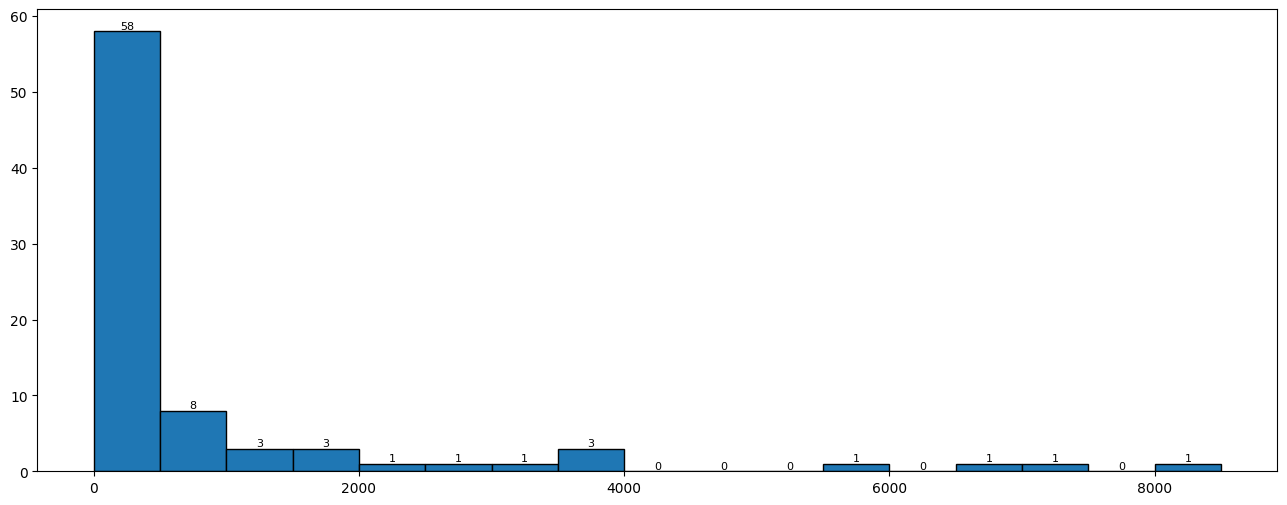

In [7]:
import matplotlib.pyplot as plt
found_ranks = [rank for rank in bge_ranks if rank != -1]
max_rank = max(found_ranks)
bin_edges = list(range(0, ((max_rank // 500) + 2) * 500, 500))
plt.figure(figsize=(16, 6))
counts, bins, patches = plt.hist(found_ranks, bins=bin_edges, edgecolor='black')
for count, bin_left, patch in zip(counts, bins, patches):
    plt.text(
        bin_left + (bins[1] - bins[0]) / 2,
        count,
        str(int(count)),
        ha='center',
        va='bottom',
        fontsize=8
    )
plt.show()

In [8]:
for i, rank in enumerate(bge_ranks):
    print(f"index: {i}, lowest index of target doi (rank - 1): {rank}")

index: 0, lowest index of target doi (rank - 1): -1
index: 1, lowest index of target doi (rank - 1): 596
index: 2, lowest index of target doi (rank - 1): 7281
index: 3, lowest index of target doi (rank - 1): 1972
index: 4, lowest index of target doi (rank - 1): 0
index: 5, lowest index of target doi (rank - 1): 24
index: 6, lowest index of target doi (rank - 1): 0
index: 7, lowest index of target doi (rank - 1): 503
index: 8, lowest index of target doi (rank - 1): -1
index: 9, lowest index of target doi (rank - 1): 468
index: 10, lowest index of target doi (rank - 1): -1
index: 11, lowest index of target doi (rank - 1): -1
index: 12, lowest index of target doi (rank - 1): 5
index: 13, lowest index of target doi (rank - 1): 1
index: 14, lowest index of target doi (rank - 1): -1
index: 15, lowest index of target doi (rank - 1): 20
index: 16, lowest index of target doi (rank - 1): 1272
index: 17, lowest index of target doi (rank - 1): 164
index: 18, lowest index of target doi (rank - 1): 

## Big Misses

Having used top-k of 10,000 even then some target references weren't retrieved. We see the 3rd example had one of the worst results where its target doi first appeared at index 7281.

Let's take a look at this example:
1. Get the example
1. Look at the sentence and the target citation
1. Look at the 7281st index to see its target chunk
1. Find out if any of the other query results after that were also from the target doi
1. Look at the top-ranked results' chunks
1. Hypothesize why their vector embeddings were so much closer

In [9]:
example = examples.iloc[2]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Building on their ideas, Priest and Syntelis ( 2021 ) '
 'developed a model in which the magnetic field is written in terms of '
 'cylindrical polar coordinates , asdue to a ring of X-points near and the '
 'field of the current sheet itself.')
('Example: Building on their ideas, Priest and  developed a model in which the '
 'magnetic field is written in terms of cylindrical polar coordinates , asdue '
 'to a ring of X-points near and the field of the current sheet itself.')
Target doi: ['10.3847/1538-4357/abec4f']


This target doi *actually* refers to *The Dynamic Formation of Pseudostreamers* (Scott et al, 2021), bibcode `2021ApJ...913...64S`. 

However, "Priest and Syntelis (2021)" should have been the target document. So in this case the example was misformed because
* the citation regex did not capture "Priest" as first author, but actually "Syntelis"
* Therefore it looked for a bibcode `2021........S"
* Which it matched to the incorrect document

### Conclusion: the dataset build pipeline misidentified a target document from an inline citation, creating a malformed example

Let's try with example 18, the worst-performing one in the dataset

In [10]:
example = examples.iloc[18]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: In an influential paper, Dalal Kochanek (2002) analyzed '
 'radio data for a sample of seven quadruply-imaged sources and reported the '
 'detection of a surface mass fraction in the form of substructure between '
 '0.6% and 7%.')
('Example: In an influential paper, Dalal  analyzed radio data for a sample of '
 'seven quadruply-imaged sources and reported the detection of a surface mass '
 'fraction in the form of substructure between 0.6% and 7%.')
Target doi: ['10.1046/j.1365-8711.2002.05438.x']


Dalal Kochanek (2002) should refer to the paper *Direct Detection of Cold Dark Matter Substructure*, bibcode `2002ApJ...572...25D` and doi " 
10.1086/340303" or "10.48550/arXiv.astro-ph/0111456". We see here the target DOI has again been malformed.

### Conclusion: malformed example

In [11]:
example = examples.iloc[19]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Although this is often interpreted as “preheating”, soft '
 'X-ray images show that in many cases the precursor, though a part of the '
 'flare, does not coincide with the structure supporting the impulsive phase '
 '(Fárník and Savy 1998), hence not reflecting the plasma conditions at the '
 'site of major energy release.')
('Example: Although this is often interpreted as “preheating”, soft X-ray '
 'images show that in many cases the precursor, though a part of the flare, '
 'does not coincide with the structure supporting the impulsive phase (Fárník '
 'and , hence not reflecting the plasma conditions at the site of major energy '
 'release.')
Target doi: ['10.1023/A:1005033717284']


### Conclusion: again, malformed example due to inline citation regex failing to capture first author

In [12]:
example = examples.iloc[33]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Prior to launch, synthetic white light WISPR images, '
 'created using the sophisticated ray-tracing software (Thernisien et al. 2009 '
 '), were used to develop new techniques for analyzing observed motions of '
 'ejecta.')
('Example: Prior to launch, synthetic white light WISPR images, created using '
 'the sophisticated ray-tracing software (, were used to develop new '
 'techniques for analyzing observed motions of ejecta.')
Target doi: ['10.1007/s11207-009-9346-5']


Thernisien et al. 2009 does refer to DOI: 10.1007/s11207-009-9346-5. So in this case the example has the correct target doi.

The input sentence refers to the ray-tracing software from Thernisien et al. 2009. So hopefully the target chunk talks about this.

Inspecting the chunk retrieved:

In [13]:
example_query_results = bge_query_results[33]
query_result_idx = bge_ranks[33]
pprint(example_query_results[query_result_idx])

VectorQueryResult(chunk_id=1216498,
                  doi='10.1007/s11207-009-9346-5',
                  title='Forward Modeling of Coronal Mass Ejections Using '
                        'STEREO/SECCHI Data',
                  abstract='We describe a forward modeling method developed to '
                           'study the coronal mass ejections observed with '
                           'STEREO/SECCHI. We present a survey of 26 CMEs '
                           'modeled with this method. We selected most of the '
                           'bright events observed since November 2007 to '
                           'August 2008, after when the separation was greater '
                           'than 40° degrees, thus showing noticeable '
                           'differences between the two views. From these '
                           'stereoscopic observations and using a geometric '
                           'model of a flux rope, we are able to determine the '
             

We see this particular chunk does not seem to be particularly similar to the sentence that cites the document, rather a part of the process described which, out of context, it would be hard to recognize as related to the input sentence.

Recompiling the paper:

In [ ]:
research_papers = pd.read_json("data/preprocessed/research.jsonl", lines=True)
print(f"Number of research papers: {len(research_papers)}")


Number of research papers: 52618


In [20]:
thernesien_paper = research_papers[research_papers["doi"] == "10.1007/s11207-009-9346-5"]
print(f"Papers found with target doi in reference data: {len(thernesien_paper)}")
thernesien_paper = thernesien_paper.iloc[0]
print(f"Title: {thernesien_paper['title']}")

Papers found with target doi in reference data: 1
Title: Forward Modeling of Coronal Mass Ejections Using STEREO/SECCHI Data


In [25]:
with open('thernesien_paper.txt', 'w') as f:
    f.write(thernesien_paper["title"])
    f.write("\n")
    f.write(thernesien_paper["abstract"])
    f.write("\n")
    f.write(thernesien_paper["body"])
    f.write("\n")

Let's take a look at the actual paper we have on hand

Reviewing the content of the paper, the ray-tracing software is only briefly mentioned in section 3 and 4 and not directly mentioned in the abstract:

> (3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view. 4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference).

Section 3 references the ray-tracing, section 4 references the software SolarSoft explicitly and more about their methodology with white-light images.

In [62]:
passage = "(3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view. 4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
embeddings = bge_embedder([example.sent_no_cit, passage])
example_embedding = embeddings[0]
passage_embedding = embeddings[1]

# Get the cosine distance between the two embeddings using numpy
def cosine_distance(a, b):
    """
    Calculate the cosine distance between two vectors.
    :param a: The first vector.
    :param b: The second vector.
    :return: The cosine distance between the two vectors.
    """
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return 1 - np.dot(a, b)
print("Cosine distance:", cosine_distance(example_embedding, passage_embedding))

Cosine distance: 0.21922433


In [63]:
section_3 = "(3) Finally, the model can be positioned in space using spherical coordinates, as shown in Figure 1(c): φ and θ are the longitude and the latitude, respectively, and γ is the tilt angle around the axis of symmetry of the model. Here, we focus only on the geometric aspect of the modeling, leaving the photometric aspect (i.e., the electron density) to be addressed in future studies. Accordingly, we do not compare the observed total brightness images directly to the corresponding total brightness rendered model images, but rather we compare the overall observed shape to what we define to be the wireframe of the hollow croissant. The wireframe representation is simply the set of points located on the surface of the croissant, where the profile of electron density is peaked. The advantage of using a wireframe is that it allows real-time rendering, whereas it requires few seconds to few minutes for a full Thomson scattering rendering. Figure 2 shows two synthetic coronagraph images and two wireframe images of the model, viewed in the same orientation as in Figures 1(a) and (b), face-on and edge-on, respectively. The two top images are generated using a ray-tracing renderer that takes full account of the Thomson scattering equations; the two bottom images show only the projection of the wireframe on the virtual CCD. This demonstrates clearly that the wireframe representation reproduces accurately the geometry of the Thomson scattering view."
section_4 = "4. The Data Although this technique can be applied to images from all the instruments of the SECCHI package, we focus our study mostly on the COR2 data since its field of view (FOV) is well adapted to observe fully developed flux-rope-like CMEs. Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
section_3_embedding = bge_embedder([section_3])[0]
section_4_embedding = bge_embedder([section_4])[0]
print("Cosine distance between section 3 and input", cosine_distance(section_3_embedding, example_embedding))
print("Cosine distance between section 4 and input", cosine_distance(section_4_embedding, example_embedding))


Cosine distance between section 3 and input 0.22012842
Cosine distance between section 4 and input 0.21376169


This substring from section 4 seems particularly relevant:

> Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference).

In [64]:
passage_2 = "Figure 2 Comparison between white-light and wireframe rendering. On top are the simulated white-light images using Thomson scattering of the GCS model as seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe views. fully developed in the COR1 FOV, while its overall structure becomes too faint and more difficult to interpret in the Heliospheric Imagers’ (HI) FOV. Nevertheless, we used COR1 data when the event could be clearly identified and followed in both COR1 views. We did not use the HI images because the flux rope appearance can be distorted by the effects of interactions with the solar wind. The images are prepared using the standard SolarSoft secchi_ prep.pro procedure. We use calibrated total brightness images from that we subtract from a pre-event image (base difference)."
embedding_2 = bge_embedder([passage_2])[0]
print("Cosine distance:", cosine_distance(passage_embedding, embedding_2))

Cosine distance: 0.037793636


This has the best cosine distance by far. Where is it in the chunks?

Compare it to the chunk the preprocessing pipeline inserted into the database:

In [31]:
chunks = db.query("SELECT chunk FROM lib WHERE doi = '10.1007/s11207-009-9346-5'")
print(f"Number of chunks found with target doi in reference data: {len(chunks)}")
chunks = [chunk[0] for chunk in chunks]

Number of chunks found with target doi in reference data: 41


In [60]:
for i, chunk in enumerate(chunks):
    if "ray-tracing renderer" in chunk:
        pprint(f"Found chunk {i}: {chunk}")
    if "The images are prepared using the standard SolarSoft" in chunk:
        pprint(f"Found chunk {i}: {chunk}")

('Found chunk 3: The two top images are generated using a ray-tracing renderer '
 'that takes full account of the Thomson scattering equations; the two bottom '
 'images show only the projection of the wireframe on the virtual CCD. This '
 'demonstrates clearly that the wireframe representation reproduces accurately '
 'the geometry of the Thomson scattering view. 4. The Data Although this '
 'technique can be applied to images from all the instruments of the SECCHI '
 'package, we focus our study mostly on the COR2 data since its field of view '
 '(FOV) is well adapted to observe fully developed flux-rope-like CMEs. '
 'Indeed, the flux rope might not be 116 A. Thernisien et al. Figure 2 '
 'Comparison between white-light and wireframe rendering. On top are the '
 'simulated white-light images using Thomson scattering of the GCS model as '
 'seen in Figures 1(a) and (b). At the bottom are the corresponding wireframe '
 'views. fully developed in the COR1 FOV, while its overall structu

Both those key phrases appear in chunk 3, which is part of section 3 and all of section 4

What would the cosine distance be to this chunk? To all chunks?

In [40]:
chunk_3_embedding = bge_embedder([chunks[3]])[0]
print(cosine_distance(chunk_3_embedding, example_embedding))

0.20967066


In [46]:
cosine_distances = []

for i, chunk in enumerate(chunks):
    embedding = bge_embedder([chunk])[0]
    cosine_distance_value = cosine_distance(embedding, example_embedding)
    cosine_distances.append(cosine_distance_value)

min_distance = min(cosine_distances)
print(f"Shortest distance of all chunks from this paper: {min_distance}")
best_idx = cosine_distances.index(min_distance)
print(f"At index: {best_idx}")
pprint(f"Chunk: {chunks[best_idx]}")

Shortest distance of all chunks from this paper: 0.20767277479171753
At index: 40
('Chunk: Astrophys. J. 628, 1061 – 1069. doi:10.1086/430846. Frazin, R.A., '
 'Kamalabadi, F.: 2005b, Rotational tomography for 3D reconstruction of the '
 'white-light and EUV corona in the post-SOHO era. Solar Phys. 228, 219 – 237. '
 'doi:10.1007/s11207-005-2764-0. Frazin, R.A., Butala, M.D., Kemball, A., '
 'Kamalabadi, F.: 2005, Time-dependent reconstruction of nonstationary objects '
 'with tomographic or interferometric measurements. Astrophys. J. 635, L197 – '
 'L200. doi:10.1086/499431. Howard, R.A., Sheeley, N.R. Jr., Michels, D.J., '
 'Koomen, M.J.: 1985, Coronal mass ejections – 1979 – 1981. J. Geophys. Res. '
 '90, 8173 – 8191. Howard, R.A., Moses, J.D., Vourlidas, A., Newmark, J.S., '
 'Socker, D.G., Plunkett, S.P., Korendyke, C.M., Cook, J.W., Hurley, A., '
 'Davila, J.M., Thompson, W.T., St Cyr, O.C., Mentzell, E., Mehalick, K., '
 'Lemen, 130 A. Thernisien et al. J.R., Wuelser, J.P., Dunc

So the chunk containing the substring with really good Strangely, an excerpt from the paper's end matter is the closest chunk by cosine distance. Were there in fact any other chunks from this paper included?

In [48]:
example_query_results = bge_query_results[33]
results_from_target_doi = [result for result in example_query_results if result.doi == "10.1007/s11207-009-9346-5"]
print(f"Number of results from target doi: {len(results_from_target_doi)}")

# No other references found except this one chunk

Number of results from target doi: 1


#### Observations so far:

1. What appears to be the most relevant passage does not clearly indicate the contribution (ray-tracing software) described by the inline citation
1. The human-preferred chunk in the database was not retrieved in the top 10000 results with 40 probes.
1. It's possible the other parts of the input sentence, referring to WISPR images and ejecta motions, may have overridden the ray-tracing citation when embedding

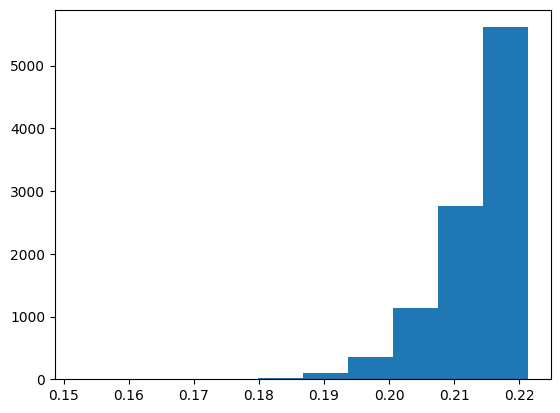

In [52]:
plt.hist([result.distance for result in example_query_results])
plt.show()

In [53]:
worse_retrieved = len([result for result in example_query_results if result.distance > 0.20967066])
print(f"Number of results with distance > 0.20967066: {worse_retrieved}")

Number of results with distance > 0.20967066: 7767


So if the database query had retrieved the true closest chunk, it still would have been ranked about 2232

#### Look at what records were deemed more similar

In [57]:
for i, result in enumerate(example_query_results[:3]):
    pprint(f"Rank {i} (distance {result.distance:.4f}): {result.chunk}") 

('Rank 0 (distance 0.1521): 3 This was shown experimentally by Piekutowski '
 '(1980) , and confirmed in our own experiments and recent code calculations. '
 'At least five different techniques have been used to measure the ejection '
 'velocity as a function of position, i.e. v ( x ): (1) Piekutowski et al. '
 '(1977) measured velocities for small explosion events by using a sheet of '
 'light perpendicular to the target surface to illuminate a single plane of '
 'the ejecta plume. A camera with a rotating shutter recorded the positions of '
 'ejecta particles at discrete times, from which their trajectories could be '
 'determined. (2) Cintala et al. (1999) improved on this method by using a '
 'strobed laser and a CCD camera to record the trajectories. Once the '
 'trajectories were known, ballistic equations were used to determine the '
 'launch position, speed and angle. (3) An optical technique originally '
 'developed in the fluid mechanics community for visualization of flow fi

Thoughts:
1. The top-ranked chunk discusses ejecta a lot.
1. The second top-ranked chunk is short, but mentions rays and forward modeling (which is what the software does)
1. The third result mentions color maps
1. None of these results seem to discuss the input sentence topic much, and neither do they have particularly close scores

### Conclusion: this would be a difficult example no matter what, but if the chunking had been more granular we might have nailed it

In [66]:
example = examples.iloc[48]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: doi:10.1086/185542 Belsole E, Worrall DM, Hardcastle MJ, '
 'Birkinshaw M, Lawrence CR (2004) XMM-Newton observations of three '
 'high-redshift radio galaxies.')
('Example: doi:10.1086/185542 Belsole E, Worrall DM, Hardcastle MJ, Birkinshaw '
 'M, Lawrence  XMM-Newton observations of three high-redshift radio galaxies.')
Target doi: ['10.1007/BF02702288']


### Conclusion: this example has very little semantic content, and appears to be from the end matter. It should not have been an example at all

In [67]:
example = examples.iloc[67]
pprint(f"Original sentence: {example.sent_original}")
pprint(f"Example: {example.sent_no_cit}")
print(f"Target doi: {example.citation_dois}")

('Original sentence: Using a theoretical HR diagram, it is possible to derive '
 'an empirical relation between A~f and the luminosity L (Lamers, 1981), and, '
 'going one step further, and A~f—M relation (since for high masses, the '
 'luminosity remains approximately constant throughout the evolution), in the '
 'form: J~f)~MI~ 2=108MoY~11 M>Mmn=20M.')
('Example: Using a theoretical HR diagram, it is possible to derive an '
 'empirical relation between A~f and the luminosity L (, and, going one step '
 'further, and A~f—M relation (since for high masses, the luminosity remains '
 'approximately constant throughout the evolution), in the form: J~f)~MI~ '
 '2=108MoY~11 M>Mmn=20M.')
Target doi: ['10.1086/158835']


This appears to be OCR errors, mistaking $\dot{M}$ for `A~f`. The original has very different notation:

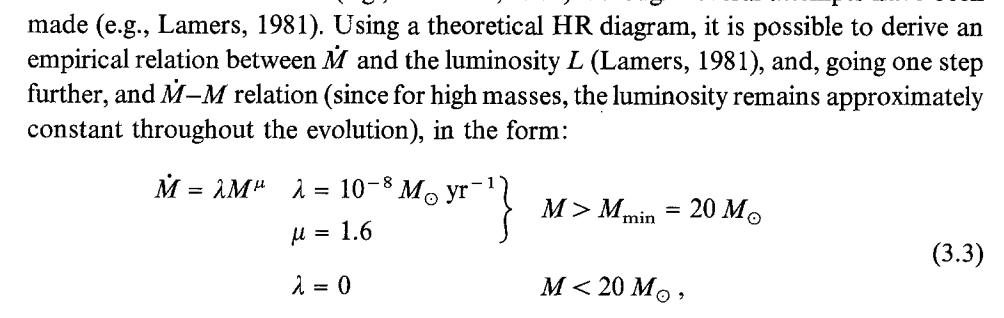

In [ ]:
# display 'data/images/gamma_rays_screenshot.png' image
from IPython.display import Image, display
display(Image(filename='data/images/gamma_rays_screenshot.png'))

This target doi is correct. It discusses
- A theoretical HR diagram
- deriving a relationship between A~f (a type of star) and luminosity

The target paper is:

In [74]:
lamers = research_papers[research_papers["doi"] == "10.1086/158835"].iloc[0]
pprint(lamers.title)
pprint(lamers.abstract)

'Mass loss from O and B stars.'
('The mass loss rates of 53 early type stars, ranging in spectral type from O3 '
 'to B9 and in luminosity class from V to Ia(+), including Of stars, are used '
 'to investigate the dependence of the mass loss rates on the stellar '
 'parameters. The mass loss rates are based on observations of the radio flux, '
 'infrared excess, UV resonance lines, and H-alpha emission as found in the '
 'literature. These four sets of mass loss rates are compared with one another '
 'and corrected for systematic differences due to differences in the adopted '
 'velocity laws, by scaling them to the rates derived from the radio flux. '
 'Expressions are obtained which describe the mass loss rates or mass fluxes; '
 'the obtained relations agree neither with the present predictions for the '
 'radiation-driven wind theory nor with those for the fluctuation theory of '
 'mass loss.')


In [75]:
with open('lamers_paper.txt', 'w') as f:
    f.write(lamers.title)
    f.write("\n")
    f.write(lamers.abstract)
    f.write("\n")
    f.write(lamers.body)
    f.write("\n")